# ACV Predicción

Los datos fueron obtenidos de un centro de salud. El dataset cuenta de 11 caracteristicas clinicas que potencialmente podrian ser usadas en un modelo de predicción de ACV.

| Variable       |        Significado     | 
|-----------------------|-----------------------|
| id            |        Identificador      |
| gender         |        Género      |
| age            |        Edad     |
| hypertension   |        Si el paciente sufre de hipertensión      |
| heart_disease  |        Si el paciente sufre de efermedad cardiovascular|
| ever_married   |        Si estuvo o no casado/a     |
| work_type      |        Tipo de empleo    |
| Residence_type |        Si vive en zona rural o urbana    |
|avg_glucose_level |      Nivel medio de azúcar en sangre      |
| bmi              |      Indice de masa corporal    |
| smoking_status   |      Si es fumador, ex-fumador, nunca fumo o no se tienen datos    |
| stroke           |      1 si el paciente sufrio ACV(ACV+) y 0 si no sufrio ACV(ACV-)    |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [2]:
# Se importa el dataset y se guarda en variable
df_stroke = pd.read_csv("stroke_dataset.csv")
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# dataframe que se utilizara más adelante para aplicar PCA
df_stroke_PCA = df_stroke.copy()

## Preprocesamiento de la data

In [4]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# se elimina la columna id porque no es relevante
df_stroke.drop(columns=['id'],inplace=True)

In [6]:
# se eliminan las filas donde en la columna gender sea igual a Other 
df_stroke.drop(index=df_stroke.index[df_stroke['gender'] == 'Other'], axis='index', inplace=True)

In [7]:
# buscando valores N/A
df_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
# reemplazando cada N/A con el promedio de los valores de bmi
df_stroke.fillna(df_stroke['bmi'].mean(), inplace=True)
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.89456,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.89456,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60000,formerly smoked,0


## Análisis Exploratorio de Datos

In [9]:
# estadistica data numerica
df_stroke.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5109.0,43.229986,22.613575,0.08,25.00,45.00,61.00,82.00
hypertension,5109.0,0.097475,0.296633,0.00,0.00,0.00,0.00,1.00
heart_disease,5109.0,0.054022,0.226084,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,5109.0,106.140399,45.285004,55.12,77.24,91.88,114.09,271.74
bmi,5109.0,28.894560,7.698235,10.30,23.80,28.40,32.80,97.60
stroke,5109.0,0.048738,0.215340,0.00,0.00,0.00,0.00,1.00


In [10]:
# estadistica data categorica
df_stroke.describe(include = 'O').T

,count,unique,top,freq
gender,5109,2,Female,2994
ever_married,5109,2,Yes,3353
work_type,5109,5,Private,2924
Residence_type,5109,2,Urban,2596
smoking_status,5109,4,never smoked,1892


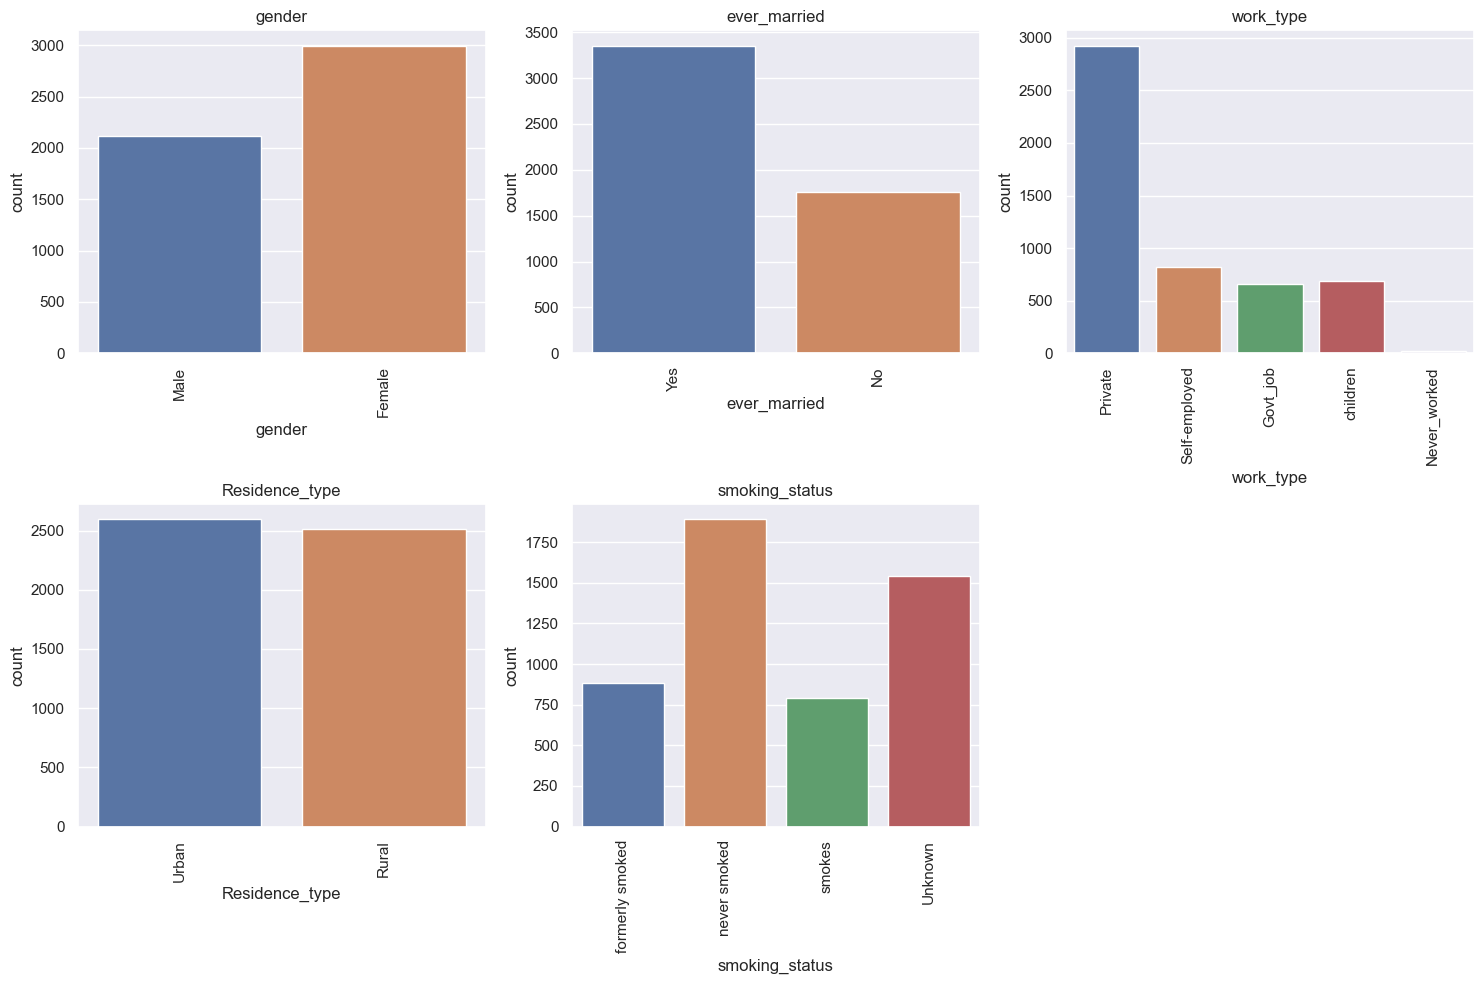

In [11]:
# obteniendo los nombres de las columnas object (columnas categoricas)
cat_vars = df_stroke.select_dtypes(include='object').columns.tolist()

# creando una figura con los subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando grafico de barras para cada variable categorica
for i, var in enumerate(cat_vars):
    top_values = df_stroke[var].value_counts().nlargest(6).index
    filtered_df = df_stroke[df_stroke[var].isin(top_values)]
    sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

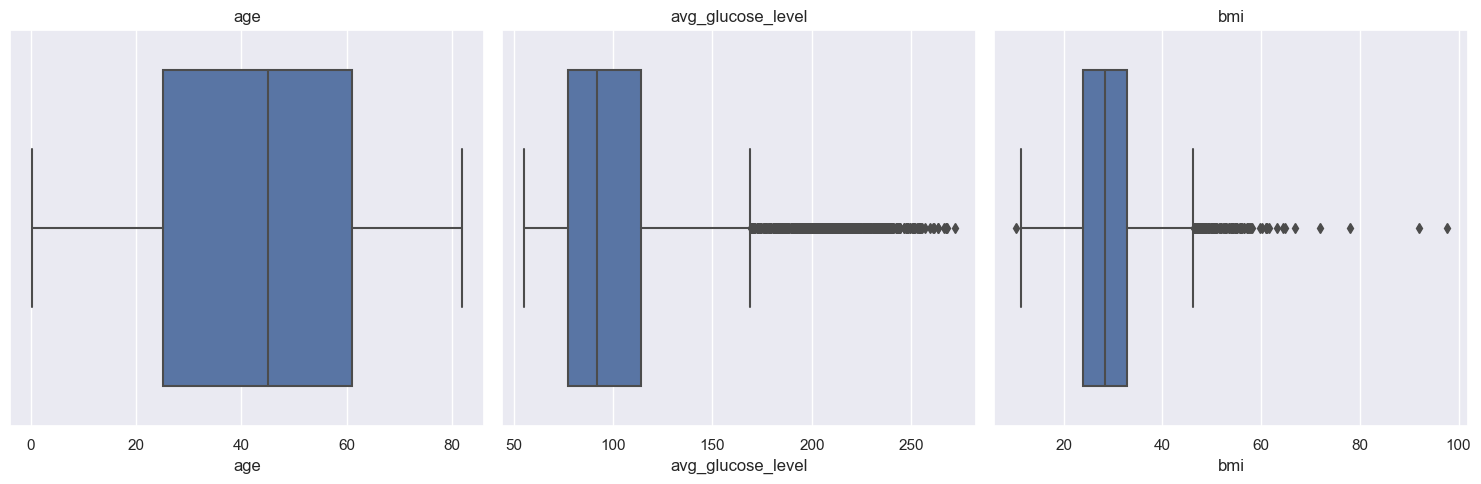

In [12]:
# obteniendo los nombres de las columnas int y float excepto stroke, hypertension, heart_disease
num_vars = df_stroke.select_dtypes(include=['int', 'float']).columns.tolist()
exclude_vars = ['stroke', 'hypertension', 'heart_disease']
num_vars = [var for var in num_vars if var not in exclude_vars]

# creando una figura con los subplots
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un grafico de barras por cada variable numerica
for i, var in enumerate(num_vars):
    sns.boxplot(x=df_stroke[var], ax=axs[i])
    axs[i].set_title(var)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

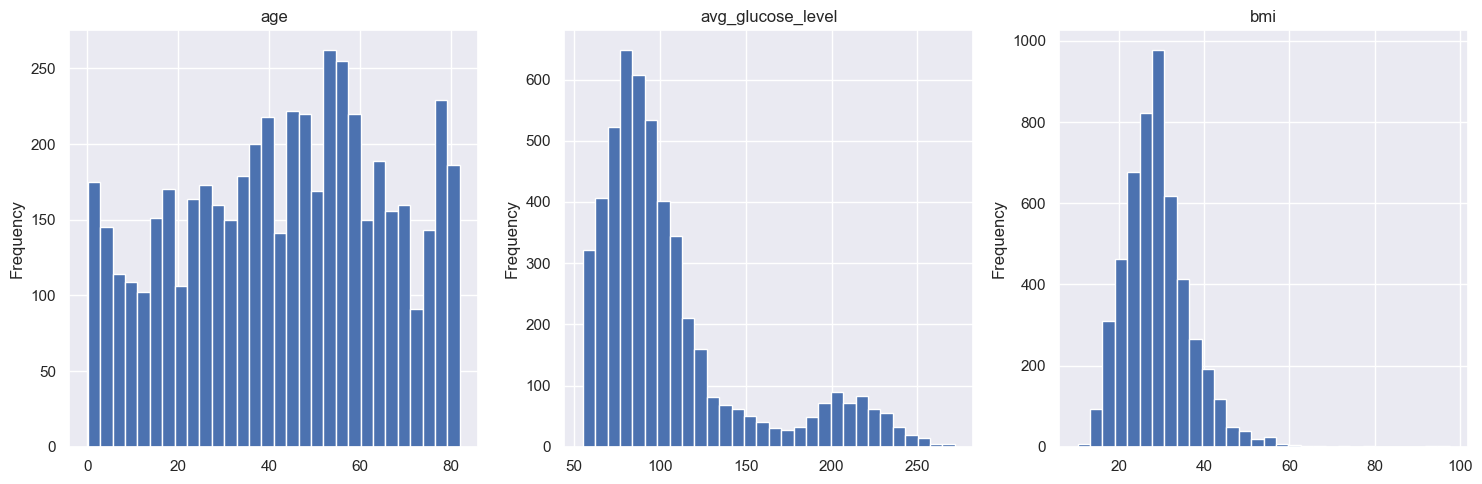

In [13]:
# Obteniendo los nombres de las columnas int y float excepto stroke, hypertension, heart_disease
int_vars = df_stroke.select_dtypes(include=['int', 'float']).columns.tolist()
exclude_vars = ['stroke', 'hypertension', 'heart_disease']
int_vars = [var for var in int_vars if var not in exclude_vars]

# creando una figura con los subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un historigrama por cada variable numerica
for i, var in enumerate(int_vars):
    df_stroke[var].plot.hist(ax=axs[i], bins=30)
    axs[i].set_title(var)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

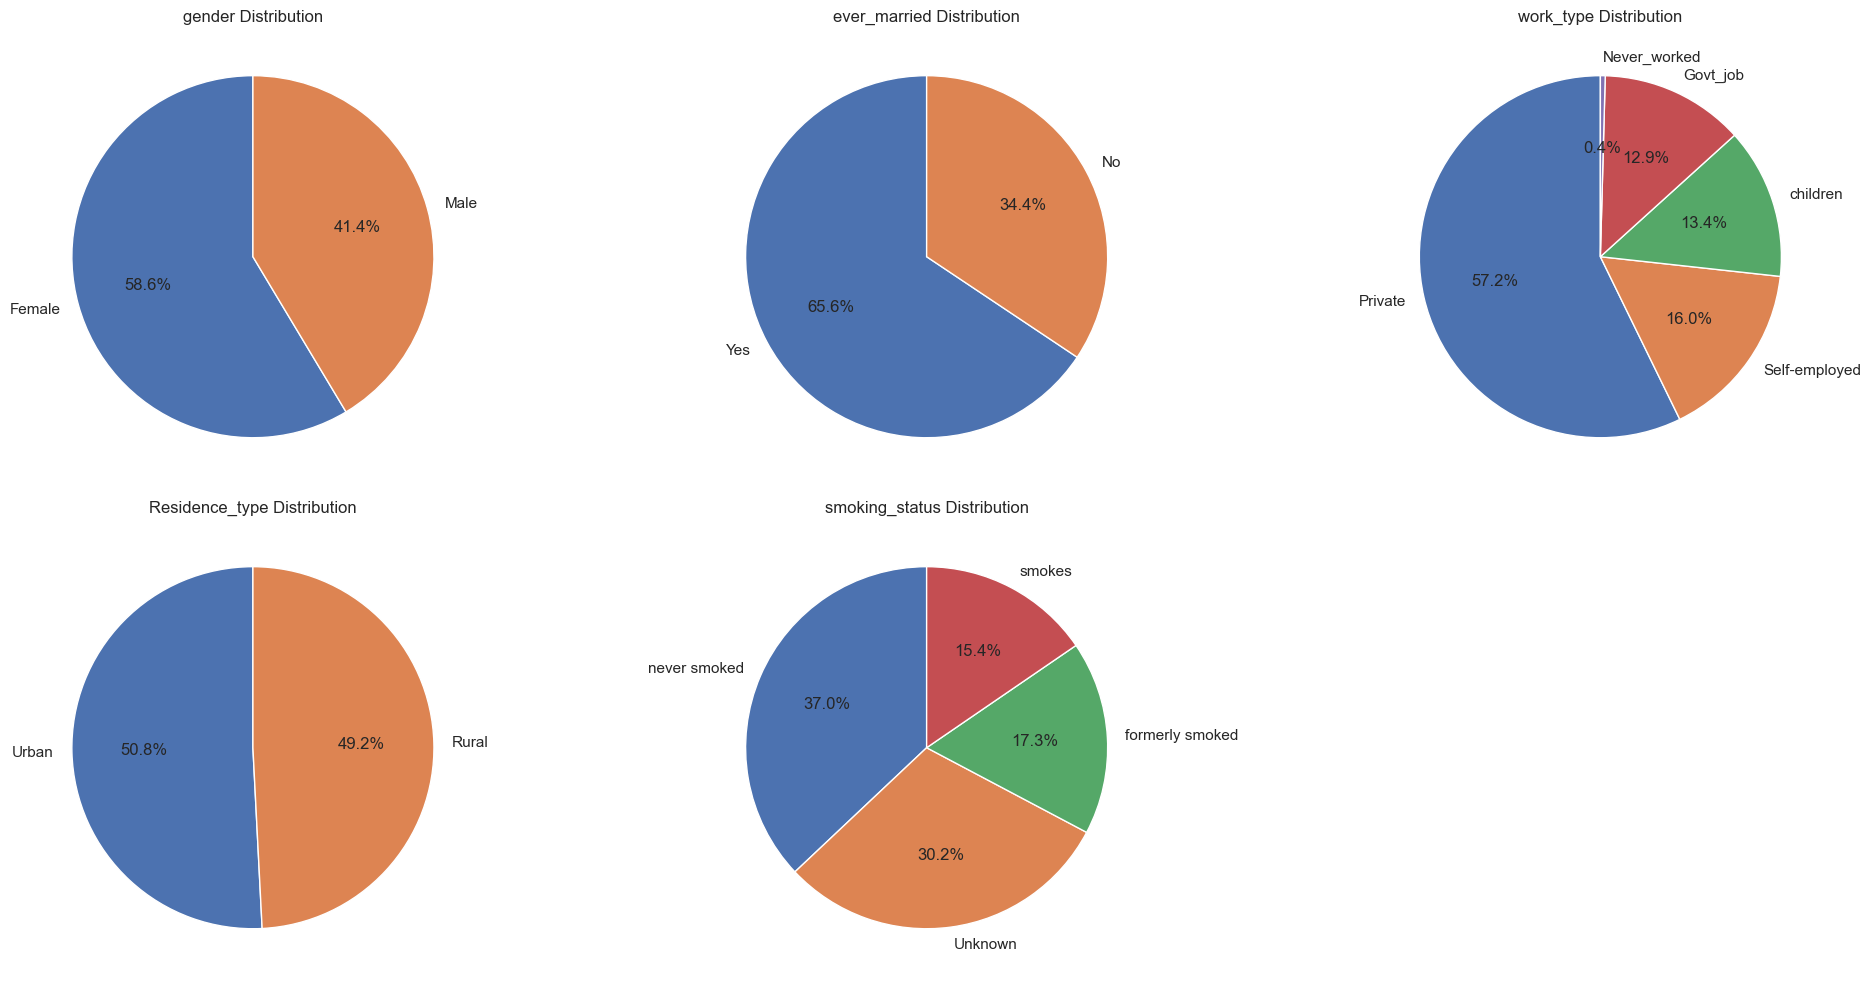

In [14]:
# especificando el número máximo de categorias a mostrar
max_categories = 5

# filtrando las varianles categoricas
cat_cols = [col for col in df_stroke.columns if col != 'y' and df_stroke[col].dtype == 'object']

# creando una figura con los subplots
num_cols = len(cat_cols)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))

# aplanando los subplots
axs = axs.flatten()

# creando un gráfico de torta por cada variable categorica
for i, col in enumerate(cat_cols):
    if i < len(axs):  # asegurando no exceder el número de subplots
        # contando el número de ocurrencias por categoria
        cat_counts = df_stroke[col].value_counts()

        # agrupa las categorias que no entran en el máximo en Other
        if len(cat_counts) > max_categories:
            cat_counts_top = cat_counts[:max_categories]
            cat_counts_other = pd.Series(cat_counts[max_categories:].sum(), index=['Other'])
            cat_counts = cat_counts_top.append(cat_counts_other)

        # crea el gráfico de torta
        axs[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'{col} Distribution')

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

### Correlación de variables con respecto a stroke

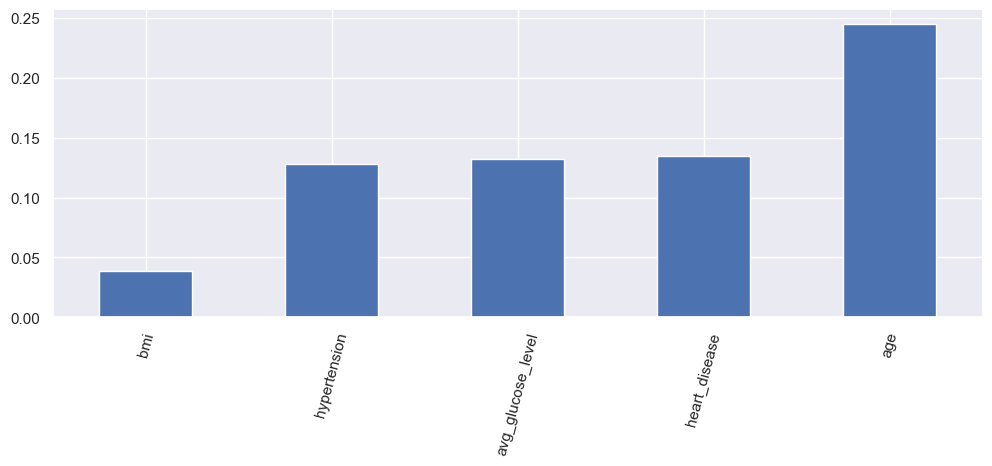

In [15]:
plt.figure(figsize=(12,4))
df_stroke.corr()['stroke'][:-1].sort_values().plot(kind='bar')
plt.xticks(rotation=75)
plt.show()

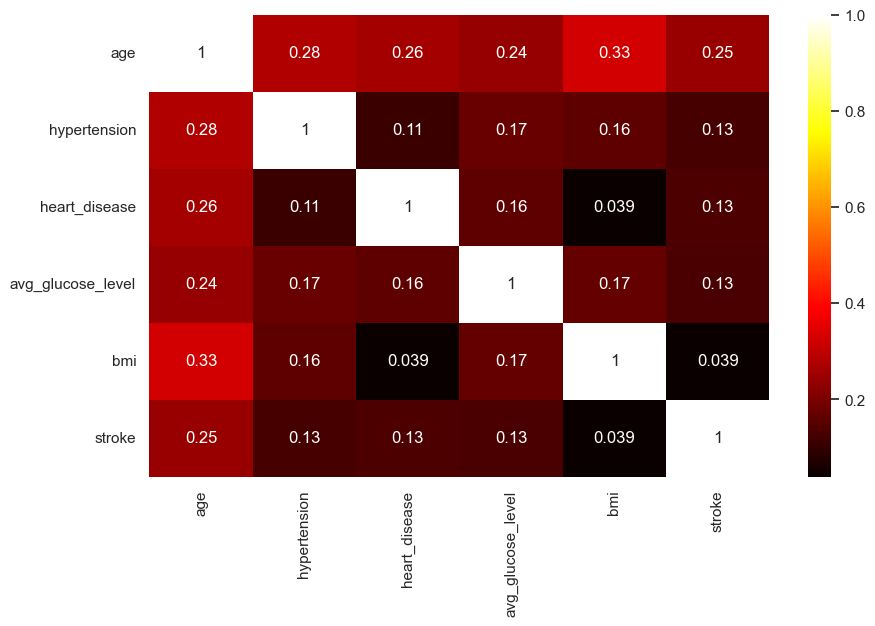

In [16]:
# Mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(df_stroke.corr(), fmt='.2g', annot=True, cmap='hot')
plt.show()

## Análisis Exploratorio de Datos para los ACV+

In [17]:
# Se crea un dataframe de gente ACV+
stroked = df_stroke[df_stroke['stroke'] == 1]

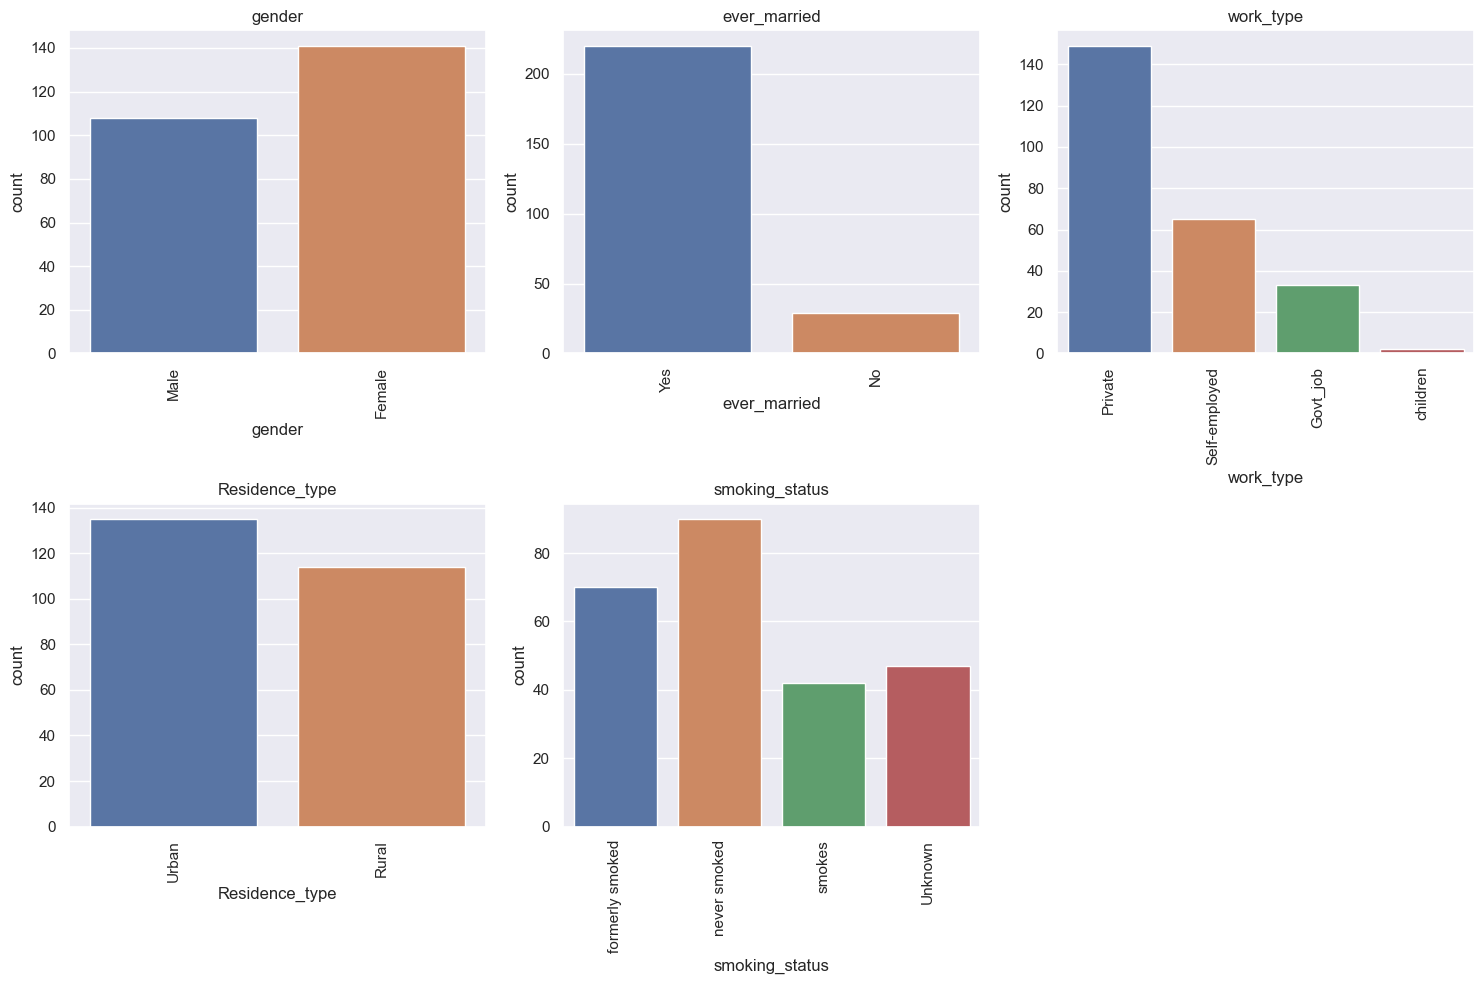

In [18]:
# obteniendo los nombres de las columnas object (columnas categoricas)
cat_vars = stroked.select_dtypes(include='object').columns.tolist()

# creando una figura con los subplots
num_cols = len(cat_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando grafico de barras para cada variable categorica
for i, var in enumerate(cat_vars):
    top_values = stroked[var].value_counts().nlargest(6).index
    filtered_df = stroked[stroked[var].isin(top_values)]
    sns.countplot(x=var, data=filtered_df, ax=axs[i])
    axs[i].set_title(var)
    axs[i].tick_params(axis='x', rotation=90)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

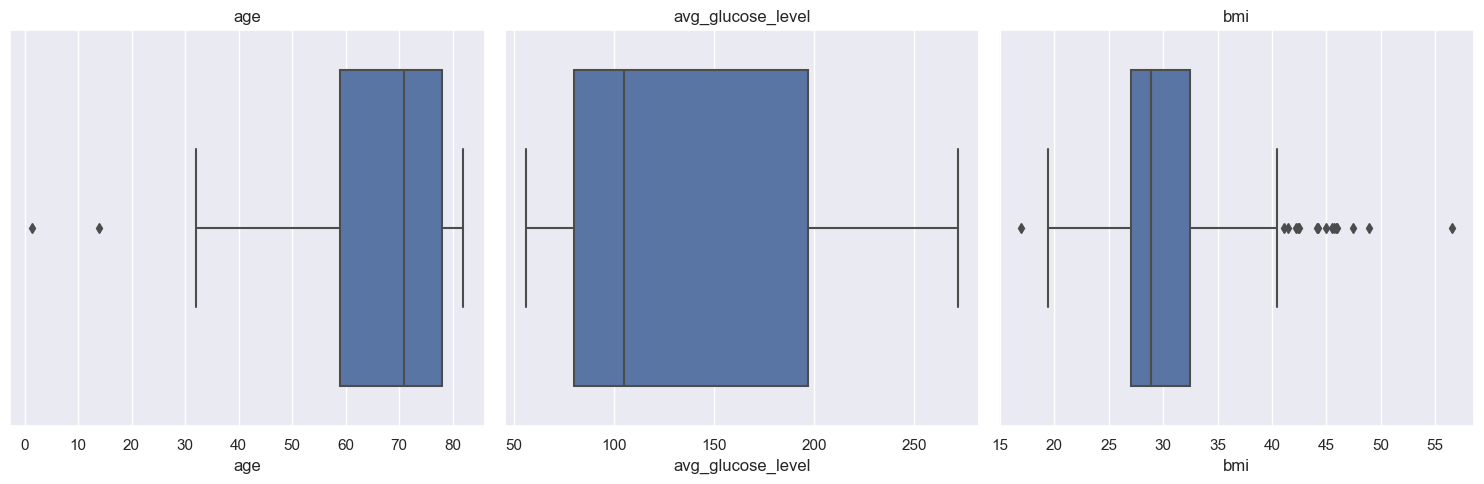

In [19]:
# Obteniendo los nombres de las columnas int y float excepto stroke, hypertension, heart_disease
num_vars = stroked.select_dtypes(include=['int', 'float']).columns.tolist()
exclude_vars = ['stroke', 'hypertension', 'heart_disease']
num_vars = [var for var in num_vars if var not in exclude_vars]

# creando una figura con los subplots
num_cols = len(num_vars)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un grafico de barras por cada variable numerica
for i, var in enumerate(num_vars):
    sns.boxplot(x=stroked[var], ax=axs[i])
    axs[i].set_title(var)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

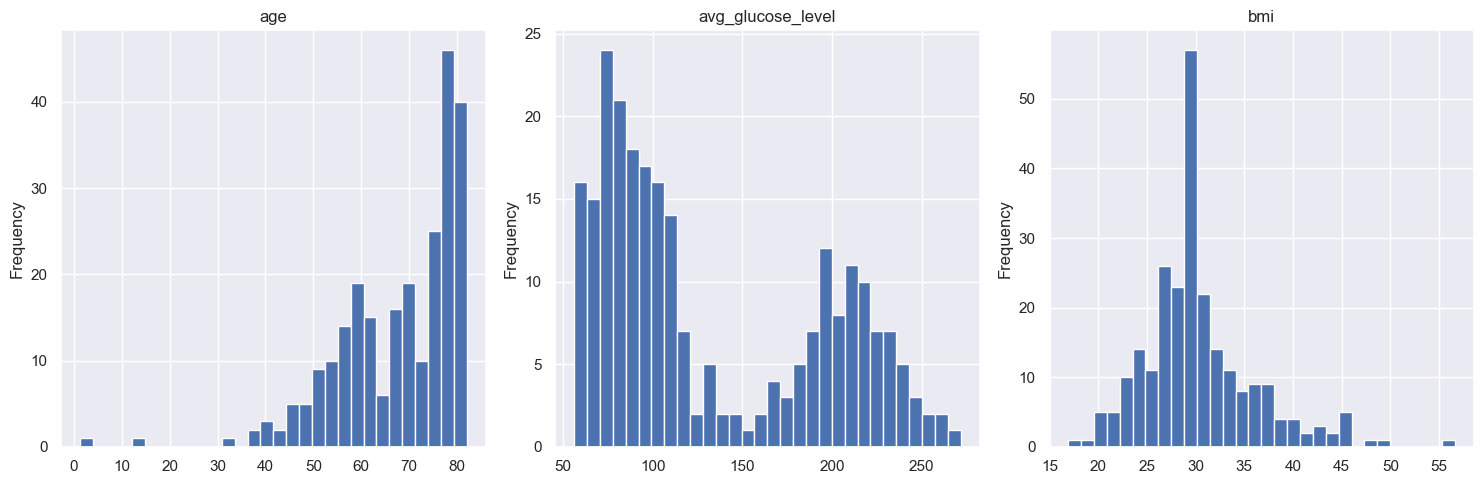

In [20]:
# Obteniendo los nombres de las columnas int y float excepto stroke, hypertension, heart_disease
int_vars = stroked.select_dtypes(include=['int', 'float']).columns.tolist()
exclude_vars = ['stroke', 'hypertension', 'heart_disease']
int_vars = [var for var in int_vars if var not in exclude_vars]

# creando una figura con los subplots
num_cols = len(int_vars)
num_rows = (num_cols + 2) // 3  
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
axs = axs.flatten()

# creando un historigrama por cada variable numerica
for i, var in enumerate(int_vars):
    stroked[var].plot.hist(ax=axs[i], bins=30)
    axs[i].set_title(var)

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

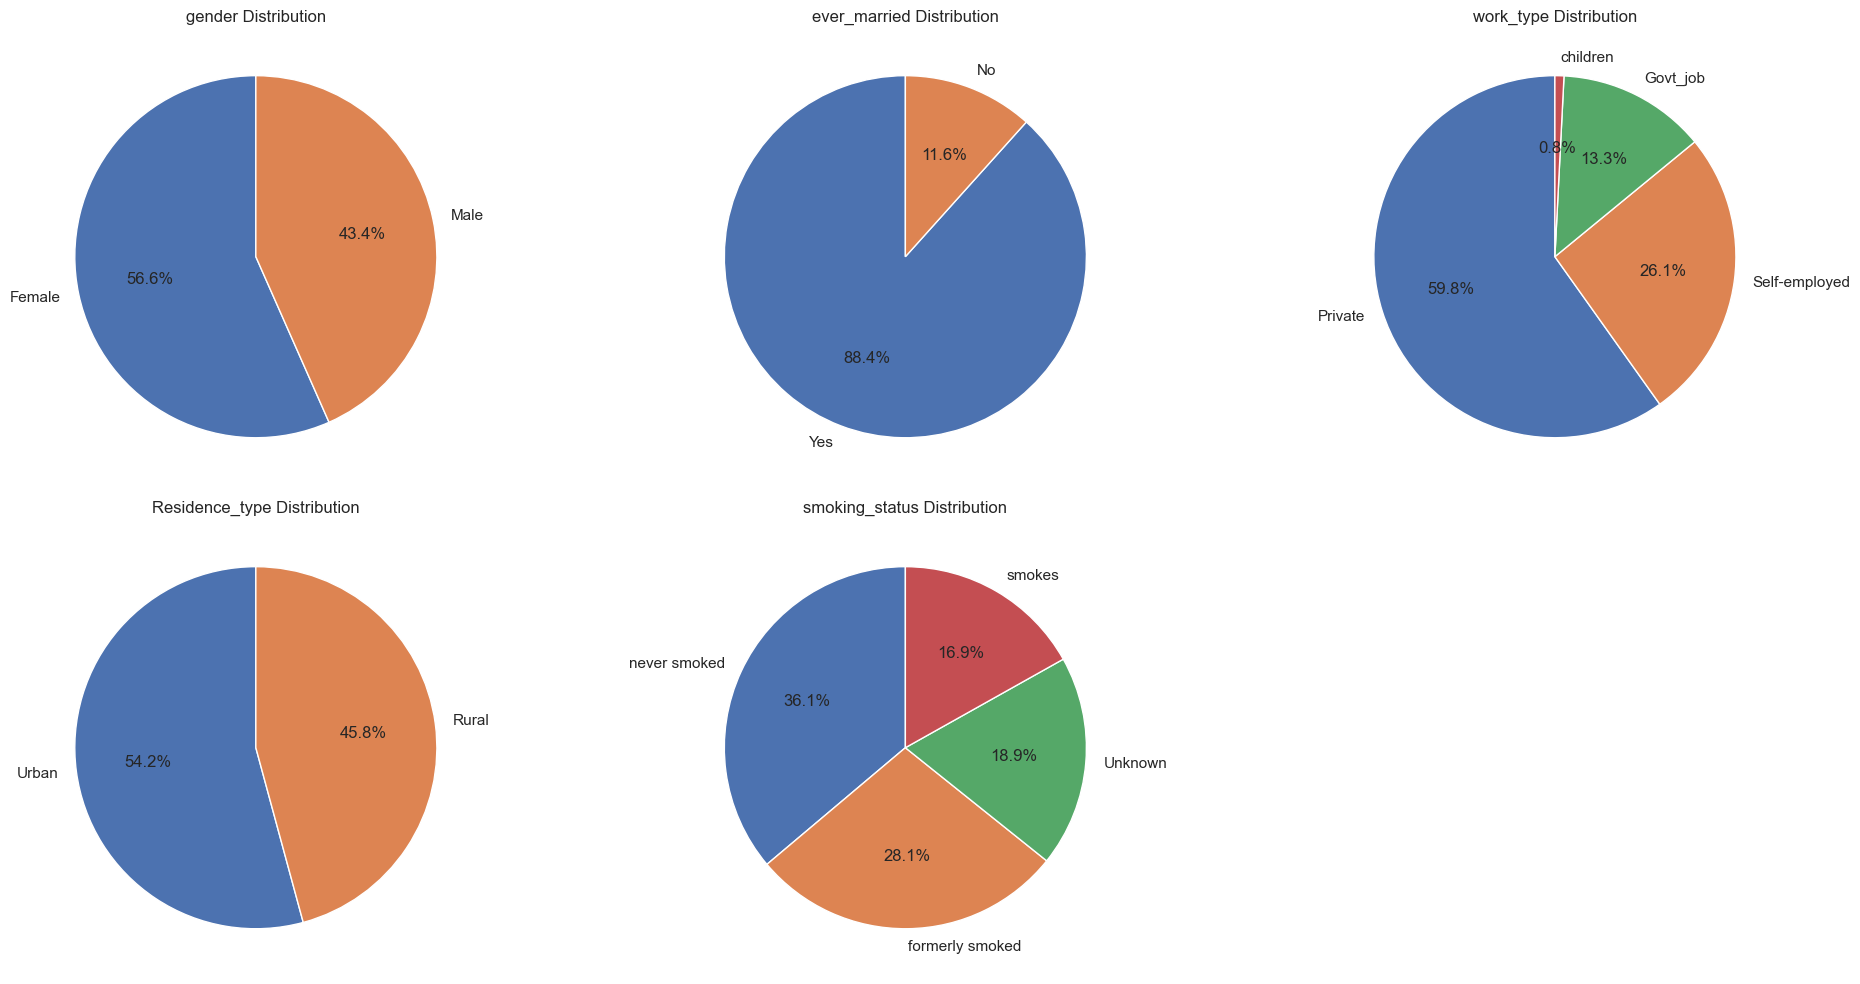

In [21]:
# especificando el número máximo de categorias a mostrar
max_categories = 5

# filtrando las varianles categoricas
cat_cols = [col for col in stroked.columns if col != 'y' and stroked[col].dtype == 'object']

# creando una figura con los subplots
num_cols = len(cat_cols)
num_rows = (num_cols + 2) // 3
fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))

# aplanando los subplots
axs = axs.flatten()

# creando un gráfico de torta por cada variable categorica
for i, col in enumerate(cat_cols):
    if i < len(axs):  # asegurando no exceder el número de subplots
        # contando el número de ocurrencias por categoria
        cat_counts = stroked[col].value_counts()

        # agrupa las categorias que no entran en el máximo en Other
        if len(cat_counts) > max_categories:
            cat_counts_top = cat_counts[:max_categories]
            cat_counts_other = pd.Series(cat_counts[max_categories:].sum(), index=['Other'])
            cat_counts = cat_counts_top.append(cat_counts_other)

        # crea el gráfico de torta
        axs[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
        axs[i].set_title(f'{col} Distribution')

# remueve los subplots que queden vacios
if num_cols < len(axs):
    for i in range(num_cols, len(axs)):
        fig.delaxes(axs[i])

# ajustando los espacios entre subplots
fig.tight_layout()

## Conversión de variables categóricas a numéricas

In [22]:
# convirtiendo variables categóricas a númericas
df_stroke = pd.get_dummies(df_stroke, columns=['smoking_status', 'ever_married', 'work_type', 'Residence_type', 'gender'])
df_stroke

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,...,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,gender_Female,gender_Male
0,67.0,0,1,228.69,36.60000,1,0,1,0,0,...,1,0,0,1,0,0,0,1,0,1
1,61.0,0,0,202.21,28.89456,1,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,80.0,0,1,105.92,32.50000,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
3,49.0,0,0,171.23,34.40000,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
4,79.0,1,0,174.12,24.00000,1,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.89456,0,0,0,1,0,...,1,0,0,1,0,0,0,1,1,0
5106,81.0,0,0,125.20,40.00000,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
5107,35.0,0,0,82.99,30.60000,0,0,0,1,0,...,1,0,0,0,1,0,1,0,1,0
5108,51.0,0,0,166.29,25.60000,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1


## Train Test Split

In [23]:
X = df_stroke.drop(columns='stroke')    
y = df_stroke['stroke']

### Evaluación de modelos

### Balance entre poblaciones por sobremuestreo

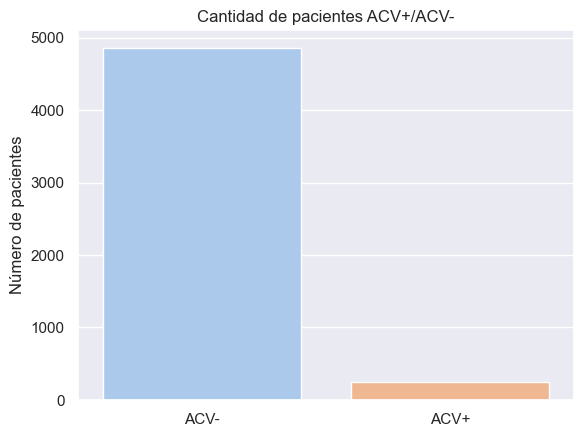

In [24]:
g = sns.countplot(data=df_stroke, x='stroke', palette='pastel')
g.set(title='Cantidad de pacientes ACV+/ACV-', ylabel ='Número de pacientes', xlabel='')
g.set_xticklabels(['ACV-', 'ACV+'])
plt.show()

SMOTE genera muestras sintéticas para la clase minoritaria con el objetivo de equilibrar la distribución de clases. Creando nuevos ejemplos sintéticos mediante la interpolación de características de ejemplos vecinos.

In [25]:
smote = SMOTE(random_state=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

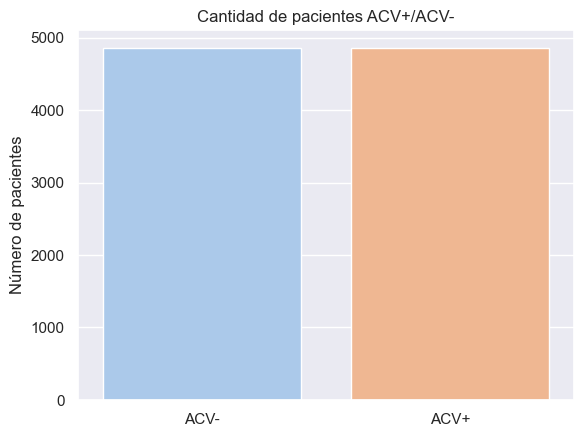

In [26]:
g = sns.countplot(x=y_resampled, palette='pastel')
g.set(title='Cantidad de pacientes ACV+/ACV-', ylabel ='Número de pacientes', xlabel='')
g.set_xticklabels(['ACV-', 'ACV+'])
plt.show()

In [27]:
# Defino datos de entrenamiento (70%) y datos de prueba(30%) .
# Random_state:Establece una semilla de múmeros aleatorios que asegura que el código sea reproducible cada vez que lo corra.
# shuffle=True: Mezcla el orden de los datos para evitar sesgos.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=2, shuffle=True)

## Regresión logística

In [28]:
# subo iteraciones del modelo porque sino no funciona. La otra es normalizar o escalar data.
# 1000 iteraciones realizaran para la optimización del modelo.

# Creo el objeto de regresión logistica.
log_reg = LogisticRegression(max_iter=1000)

# Entreno el modelo con mis datos de entrenamiento
log_reg.fit(X_train, y_train)

# Uso las variables independientes de prueba para predecir variables de salida(dependientes).
y_pred = log_reg.predict(X_test)

In [29]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1465
           1       1.00      0.92      0.96      1451

    accuracy                           0.96      2916
   macro avg       0.96      0.96      0.96      2916
weighted avg       0.96      0.96      0.96      2916



Logistic Regression Model Accuracy: 95.88%
Logistic Regression Model Recall: 91.87%
Logistic Regression Model f1 score: 95.69%
Logistic Regression Model MAE: 4.12%
Logistic Regression Model RMSE: 20.29%


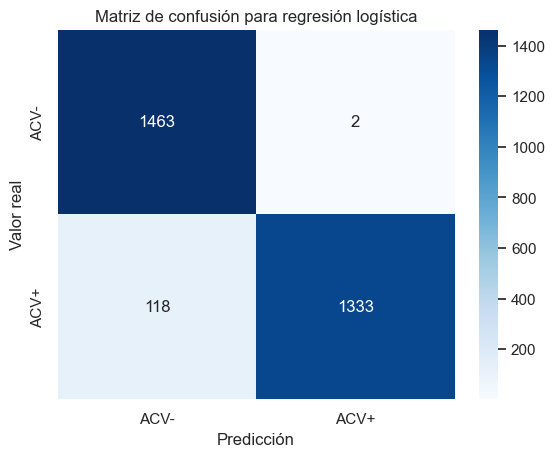

In [30]:
# evaluación del modelo de regresión logística
log = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
log.set(title='Matriz de confusión para regresión logística', ylabel ='Valor real', xlabel='Predicción')
log.set_xticklabels(['ACV-', 'ACV+']) 
log.set_yticklabels(['ACV-', 'ACV+'])

print(f'Logistic Regression Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model Recall: {recall_score(y_test, y_pred) * 100:.2f}%')
print(f'Logistic Regression Model f1 score: {metrics.f1_score(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model MAE: {metrics.mean_absolute_error(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))*100:.2f}%')

### k-Nearest Neightbors (k-NN)

In [31]:
# Creo una instancia del modelo KNN con k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entreno el modelo con los datos de entrenamiento
knn.fit(X_train, y_train)

# Predigo las etiquetas de clase para los datos de prueba
y_pred = knn.predict(X_test)

In [32]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1465
           1       0.84      0.99      0.91      1451

    accuracy                           0.90      2916
   macro avg       0.91      0.90      0.90      2916
weighted avg       0.91      0.90      0.90      2916



KNN Model Accuracy: 90.02%
KNN Recall: 98.62%
KNN Model f1 score: 90.77%
KNN MAE: 9.98%
KNN RMSE: 31.59%


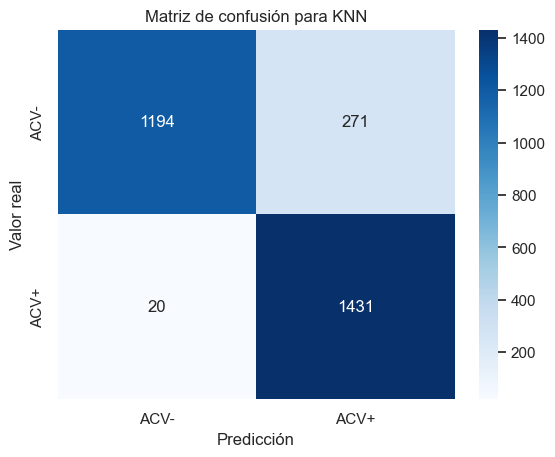

In [33]:
# evaluación del modelo KNN
kn = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
kn.set(title='Matriz de confusión para KNN', ylabel ='Valor real', xlabel='Predicción')
kn.set_xticklabels(['ACV-', 'ACV+']) 
kn.set_yticklabels(['ACV-', 'ACV+'])

print(f'KNN Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'KNN Recall: {recall_score(y_test, y_pred) * 100:.2f}%')
print(f'KNN Model f1 score: {metrics.f1_score(y_test, y_pred)*100:.2f}%')
print(f'KNN MAE: {metrics.mean_absolute_error(y_test, y_pred)*100:.2f}%')
print(f'KNN RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))*100:.2f}%')

## PCA (Principal Component Analysis)

PCA es una técnica de reducción de dimensionalidad utilizada para extraer las características más importantes de un conjunto de datos y transformarlos en un nuevo espacio de menor dimensión. Su objetivo principal es capturar la variabilidad y estructura de los datos, eliminando la redundancia y el ruido.

Para realizar el PCA, se debe partir de un dataset sin modificar. Para ello, se realizó una copia del dataset original y se aplicaron las modificaciones necesarias en el mismos.

In [34]:
df_stroke_PCA.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [35]:
#Relleno los n/a
df_stroke_PCA.fillna(df_stroke_PCA['bmi'].mean(), inplace=True)

#Transformo variables categóricas a numericas
df_stroke_PCA = pd.get_dummies(df_stroke_PCA, columns=['smoking_status', 'ever_married', 'work_type', 'Residence_type', 'gender'])

#Defino X e y
X = df_stroke_PCA.drop(columns='stroke')    
y = df_stroke_PCA['stroke']

# Balanceo el dataset
smote = SMOTE(random_state=2)
X_resampled_PCA, y_resampled_PCA = smote.fit_resample(X, y)

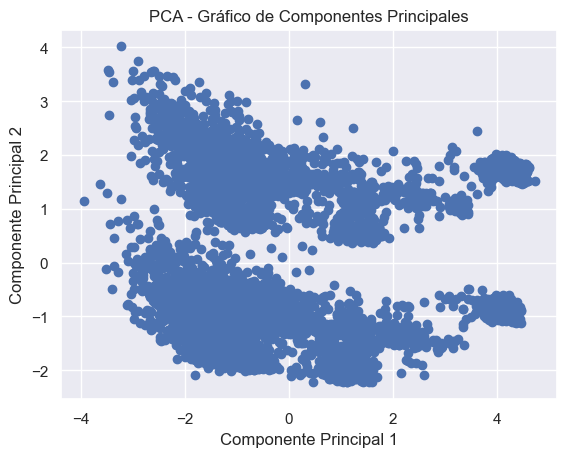

In [36]:
# Estandarizo los datos (no cambia el PCA pero es buena practica)
scaler = StandardScaler()
df_stroke_std = scaler.fit_transform(df_stroke_PCA)

# Instancio el PCA con 2 componentes principales
pca = PCA(n_components=2)

# Ajusto el PCA a los datos estandarizados
componentes_principales = pca.fit_transform(df_stroke_std)

# Grafico los componentes principales
plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Gráfico de Componentes Principales')
plt.show()

## Train Test Split PCA

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_PCA, y_resampled_PCA, test_size=0.2, random_state=2)

### Evaluación de modelos

### Regresión logistica con PCA

In [38]:
# Entreno el modelo utilizando los datos de entrenamiento
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predigo las etiquetas utilizando los datos de prueba
y_pred = log_reg.predict(X_test)

In [39]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       973
           1       0.96      0.93      0.94       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



Logistic Regression Model Accuracy: 94.45%
Logistic Regression Model Recall: 92.80%
Logistic Regression Model f1 score: 94.35%
Logistic Regression Model MAE: 5.55%
Logistic Regression Model RMSE: 23.56%


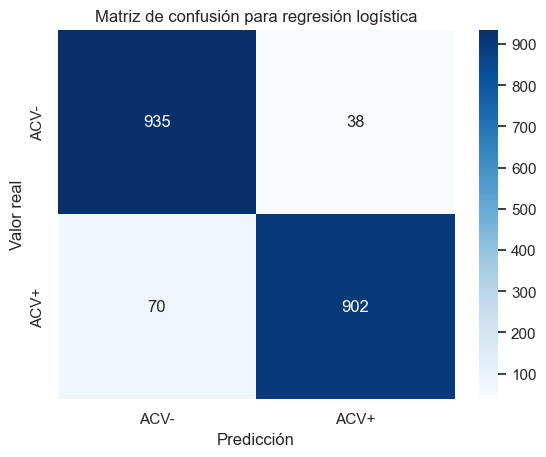

In [40]:
# evaluación del modelo de regresión logística
log = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
log.set(title='Matriz de confusión para regresión logística', ylabel ='Valor real', xlabel='Predicción')
log.set_xticklabels(['ACV-', 'ACV+']) 
log.set_yticklabels(['ACV-', 'ACV+'])

print(f'Logistic Regression Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model Recall: {recall_score(y_test, y_pred) * 100:.2f}%')
print(f'Logistic Regression Model f1 score: {metrics.f1_score(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model MAE: {metrics.mean_absolute_error(y_test, y_pred)*100:.2f}%')
print(f'Logistic Regression Model RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))*100:.2f}%')

### k-NN con PCA

In [41]:
# Creo una instancia del modelo KNN con k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Entreno el modelo con los datos de entrenamiento
knn.fit(X_train, y_train)

# Predigo las etiquetas de clase para los datos de prueba
y_pred = knn.predict(X_test)

In [42]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       973
           1       0.78      0.86      0.82       972

    accuracy                           0.81      1945
   macro avg       0.81      0.81      0.81      1945
weighted avg       0.81      0.81      0.81      1945



KNN Model Accuracy: 80.93%
KNN Recall: 86.11%
KNN Model f1 score: 81.86%
KNN MAE: 19.07%
KNN RMSE: 43.67%


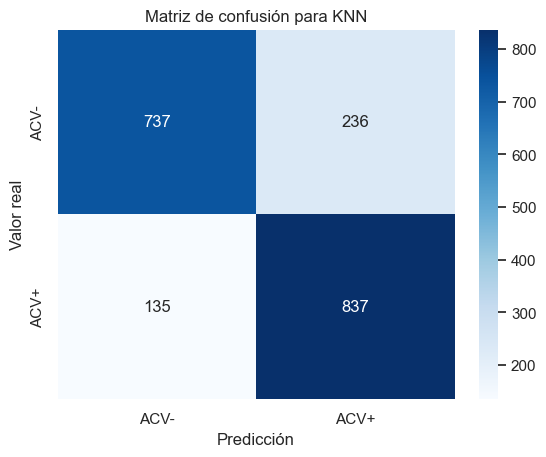

In [43]:
# evaluación del modelo KNN
kn = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
kn.set(title='Matriz de confusión para KNN', ylabel ='Valor real', xlabel='Predicción')
kn.set_xticklabels(['ACV-', 'ACV+']) 
kn.set_yticklabels(['ACV-', 'ACV+'])

print(f'KNN Model Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
print(f'KNN Recall: {recall_score(y_test, y_pred) * 100:.2f}%')
print(f'KNN Model f1 score: {metrics.f1_score(y_test, y_pred)*100:.2f}%')
print(f'KNN MAE: {metrics.mean_absolute_error(y_test, y_pred)*100:.2f}%')
print(f'KNN RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))*100:.2f}%')

## Conclusiones

Luego de un detallado análisis de las variables del dataset y de como esta influyen en los grupos ACV+ y ACV-, se procedió a la prueba de diferentes modelos de predicción a partir del dataset y de un PCA de los datos.
A continuación, se resumen las metricas de los modelos evaluados:


| Modelo                |        Precision      | Recall                |F1-score              | Falsos negativos|
|-----------------------|-----------------------|-----------------------|-----------------------|-----------|
| Regresión logistica        | 0.96          | 0.92                     |0.96                   |118|      
| k-NN                       |  0.90         | 0.99                     |0.91                   |20|     
| Regresión logistica + PCA  |  0.94         |0.93                      |0.94                   |70 |
| k-NN + PCA                 | 0.81         | 0.86                     |0.82                    |135|


El algoritmo de k-NN  se consideró el más adecuado. Si bien no predice con la misma precisión que un modelo de regresión logística, k-NN  generó una menor cantidad de falsos negativos que el resto de los modelos (es decir pacientes posiblemente ACV+ que son etiquetados como ACV-). En este caso, al tratarse de predicción relacionada a una enfermedad, es de vital importancia que este número sea lo más bajo posible.

## Sistema de predicción

In [44]:
def prediction (data):
    input_data_as_numpy_array= np.asarray(data)

    input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

    prediction = knn.predict(input_data_reshaped)
    
    print(f'El resultado es {prediction[0]}')

    if (prediction[0]== 0):
      print('La persona es ACV-')
    else:
      print('La persona es ACV+')